In [1]:
import os

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '../'))
os.chdir(project_root)

import sys
sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

from killed_diffusion import killed_diffusion

In [3]:
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['figure.figsize'] = (30,6)

In [5]:
# Parameters:
K=100.0
r=0.05
T=1.0
sigma=0.22
N=500
M=15000
L=80
B=120

# Classic call

In [57]:
call_bs = []
underlying = []
for i in range(500):
    S0 = 0.2 * i + 50.0
    price = killed_diffusion.bs_european_call(S0, K, r, T, sigma)
    call_bs.append(price)
    underlying.append(S0)

In [58]:
call_mc = []
underlying = []
for i in range(500):
    S0 = 0.2 * i + 50.0
    price = killed_diffusion.price_european_call(S0, K, r, T, sigma, N, M)
    call_mc.append(price)
    underlying.append(S0)

Text(0.5, 1.0, 'Vanilla option price - Classic european call with strike $K=100$')

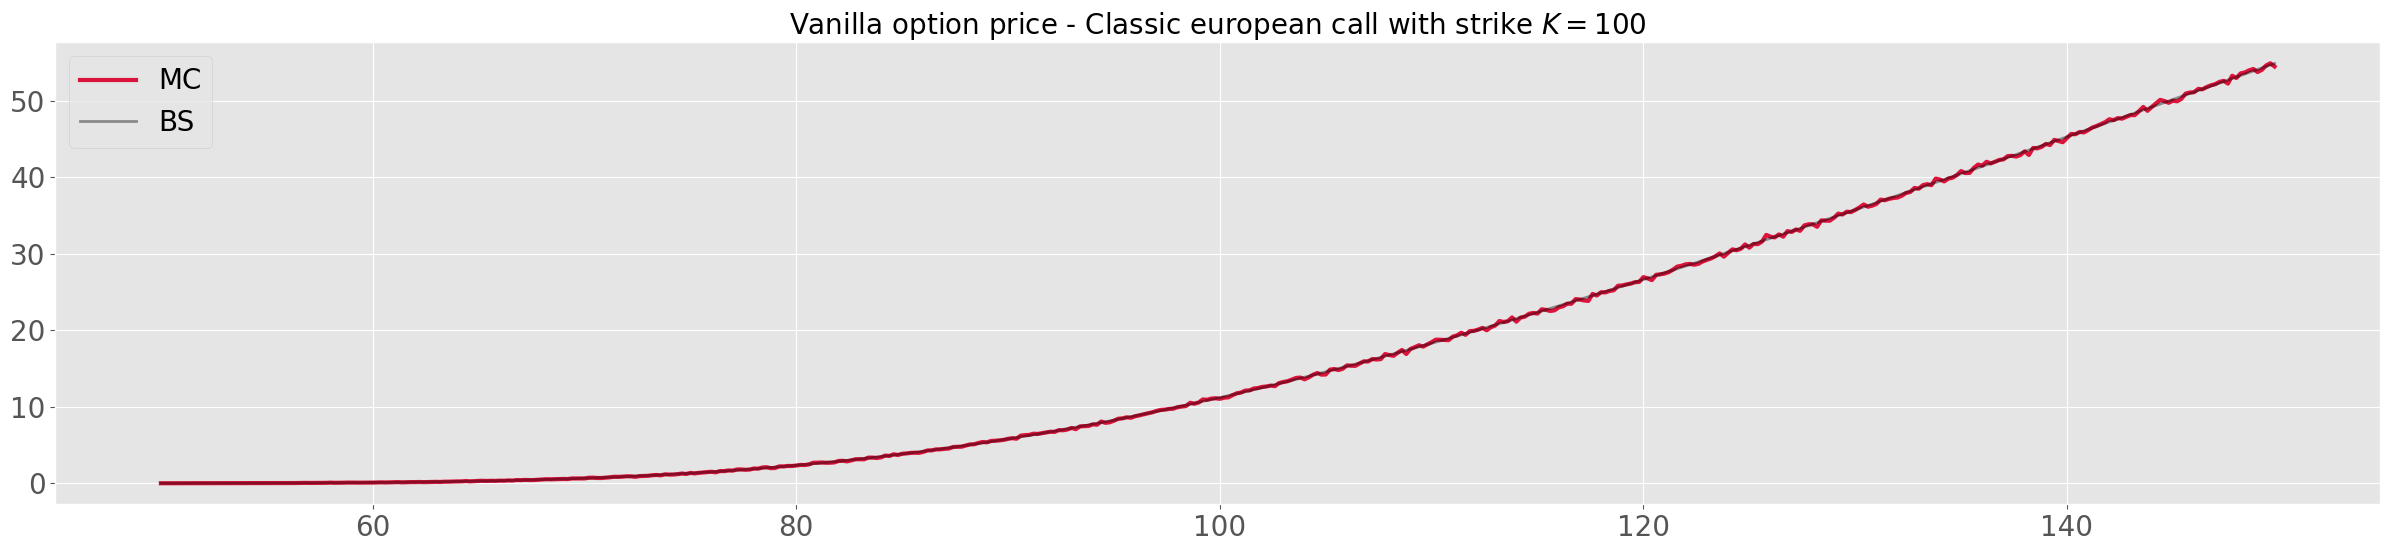

In [68]:
fig, ax = plt.subplots()
ax.plot(underlying, call_mc, c='crimson', label='MC', linewidth=3)
ax.plot(underlying, call_bs, c='black', label='BS', linewidth=2, alpha=0.4)
ax.legend()
ax.set_title(r'Vanilla option price - Classic european call with strike $K=100$')

In [69]:
fig.savefig("killed_diffusion/report/img/vanilla_call.pdf", format="pdf", bbox_inches='tight')

# Call up-and-out

In [9]:
%timeit killed_diffusion.price_barrier_call_up_and_out_gobet(80, K, r, T, sigma, N, M, B, k_limit=10)

379 ms ± 910 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
cuo = []
underlying = []
for i in range(500):
    S0 = 0.2 * i + 50.0
    price = killed_diffusion.price_barrier_call_up_and_out(S0, K, r, T, sigma, N, M, B)
    cuo.append(price)
    underlying.append(S0)

In [33]:
cuo_gobet = []
underlying = []
for i in range(500):
    S0 = 0.2 * i + 50.0
    price = killed_diffusion.price_barrier_call_up_and_out_gobet(S0, K, r, T, sigma, N, M, B, k_limit=10)
    cuo_gobet.append(price)
    underlying.append(S0)

In [34]:
cuo_bs = []
underlying = []
for i in range(500):
    S0 = 0.2 * i + 50.0
    price = killed_diffusion.bs_barrier_call_up_and_out(S0, K, r, T, sigma, B)
    cuo_bs.append(price)
    underlying.append(S0)

Text(0.5, 1.0, 'Barrier option price - Call up-and-out with strike $K=100$, barrier $B=120$')

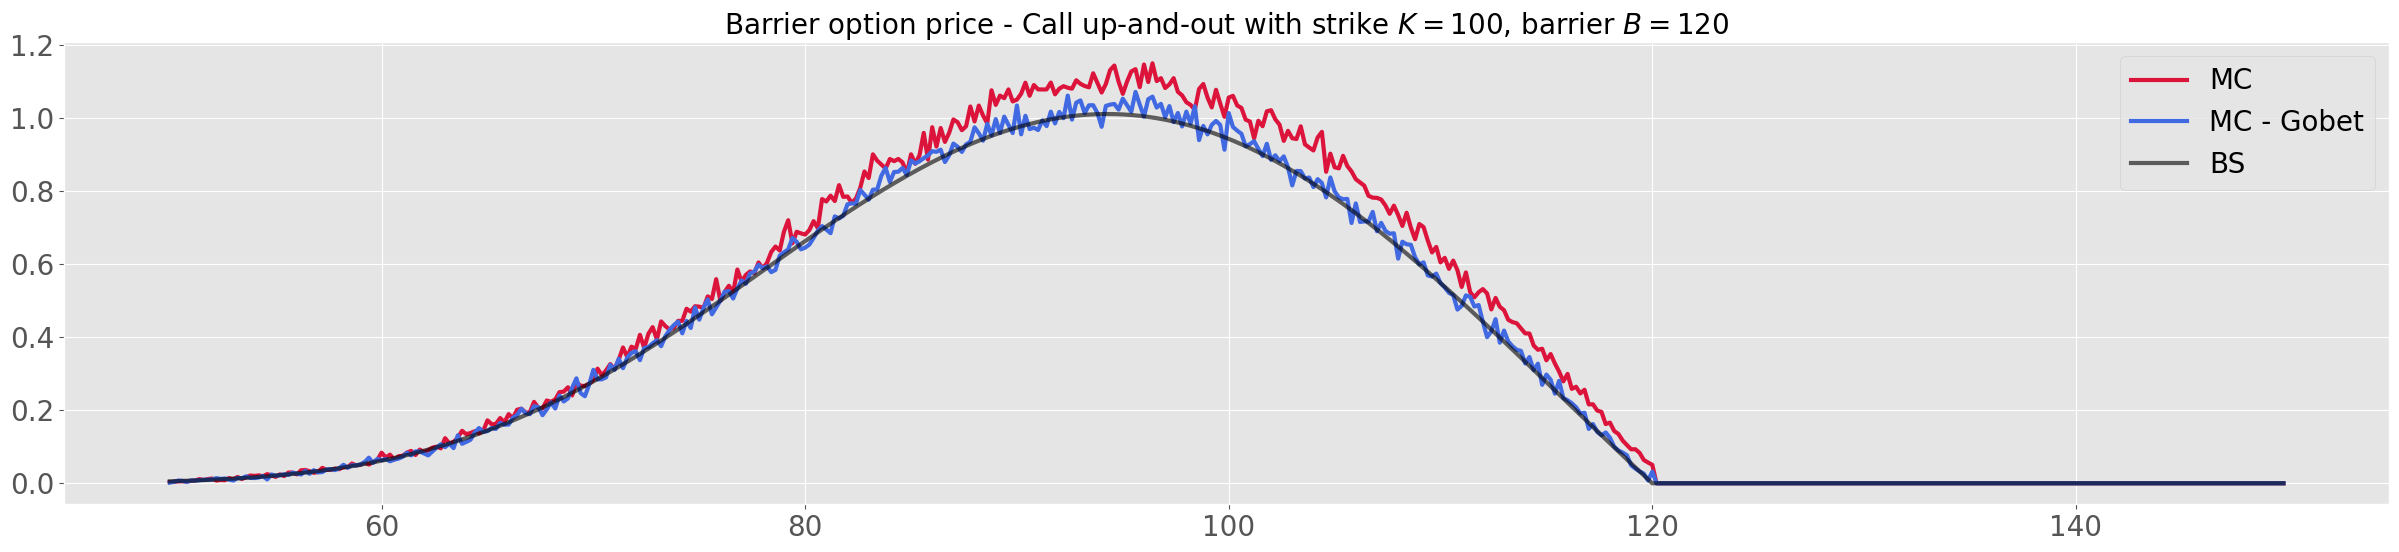

In [73]:
fig, ax = plt.subplots()
ax.plot(underlying, cuo, c='crimson', label='MC', linewidth=3)
ax.plot(underlying, cuo_gobet, c='royalblue', label='MC - Gobet', linewidth=3)
ax.plot(underlying, cuo_bs, c='black', label='BS', linewidth=3, alpha=0.6)
ax.legend()
ax.set_title(r'Barrier option price - Call up-and-out with strike $K=100$, barrier $B=120$')

In [74]:
fig.savefig("killed_diffusion/report/img/cuo_mc.png", format="png", bbox_inches='tight')

# Double no-touch

In [26]:
dnt = []
underlying = []
for i in range(500):
    S0 = 0.2 * i + 50.0
    price = killed_diffusion.price_double_no_touch_call(S0, K, r, T, sigma, N, M, L, B)
    dnt.append(price)
    underlying.append(S0)

In [27]:
dnt_gobet = []
underlying = []
for i in range(500):
    S0 = 0.2 * i + 50.0
    price = killed_diffusion.price_double_no_touch_call_gobet(S0, K, r, T, sigma, N, M, L, B, k_limit=10)
    dnt_gobet.append(price)
    underlying.append(S0)

In [13]:
# Ok, let's hotfix the dnt theoretical price in python:

def dnt_func(S0, K, r, T, sigma, L, B):
    if S0 < L or S0 > B:
        return 0
    
    alpha = 1/2 - r / sigma**2
    beta = r + 1/2*sigma**2*alpha**2
    H = np.log(B / L)
    
    sum_value = 0
    for n in range(1, 100):
        term1 = (1 - (-1)**n * np.exp(-alpha * H)) / (alpha**2 * H**2 + n**2 * np.pi**2)
        term2 = np.exp(-0.5 * sigma**2 * (n**2 * np.pi**2 / H**2) * T)
        term3 = np.sin(n * np.pi / H * np.log(S0 / L))
        sum_value += n * term1 * term2 * term3
    
    result = 2 * np.pi * (S0 / L)**alpha * np.exp(-beta * T) * sum_value
    return result

In [14]:
def python_dnt_close():
    dnt_bs = []
    underlying = []
    for i in range(500):
        S0 = 0.2 * i + 50.0
        price = dnt_func(S0, K, r, T, sigma, L, B)
        dnt_bs.append(price)
        underlying.append(S0)

In [15]:
def cpp_dnt_close():
    dnt_bs = []
    underlying = []
    for i in range(500):
        S0 = 0.2 * i + 50.0
        price = killed_diffusion.bs_dnt(S0, K, r, T, sigma, L, B)
        dnt_bs.append(price)
        underlying.append(S0)

In [16]:
%timeit python_dnt_close()

47.5 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit cpp_dnt_close()

494 µs ± 5.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
# C++ ios blazingly fast!!

Text(0.5, 1.0, 'Double no-touch option price with barriers $L=80, B=120$')

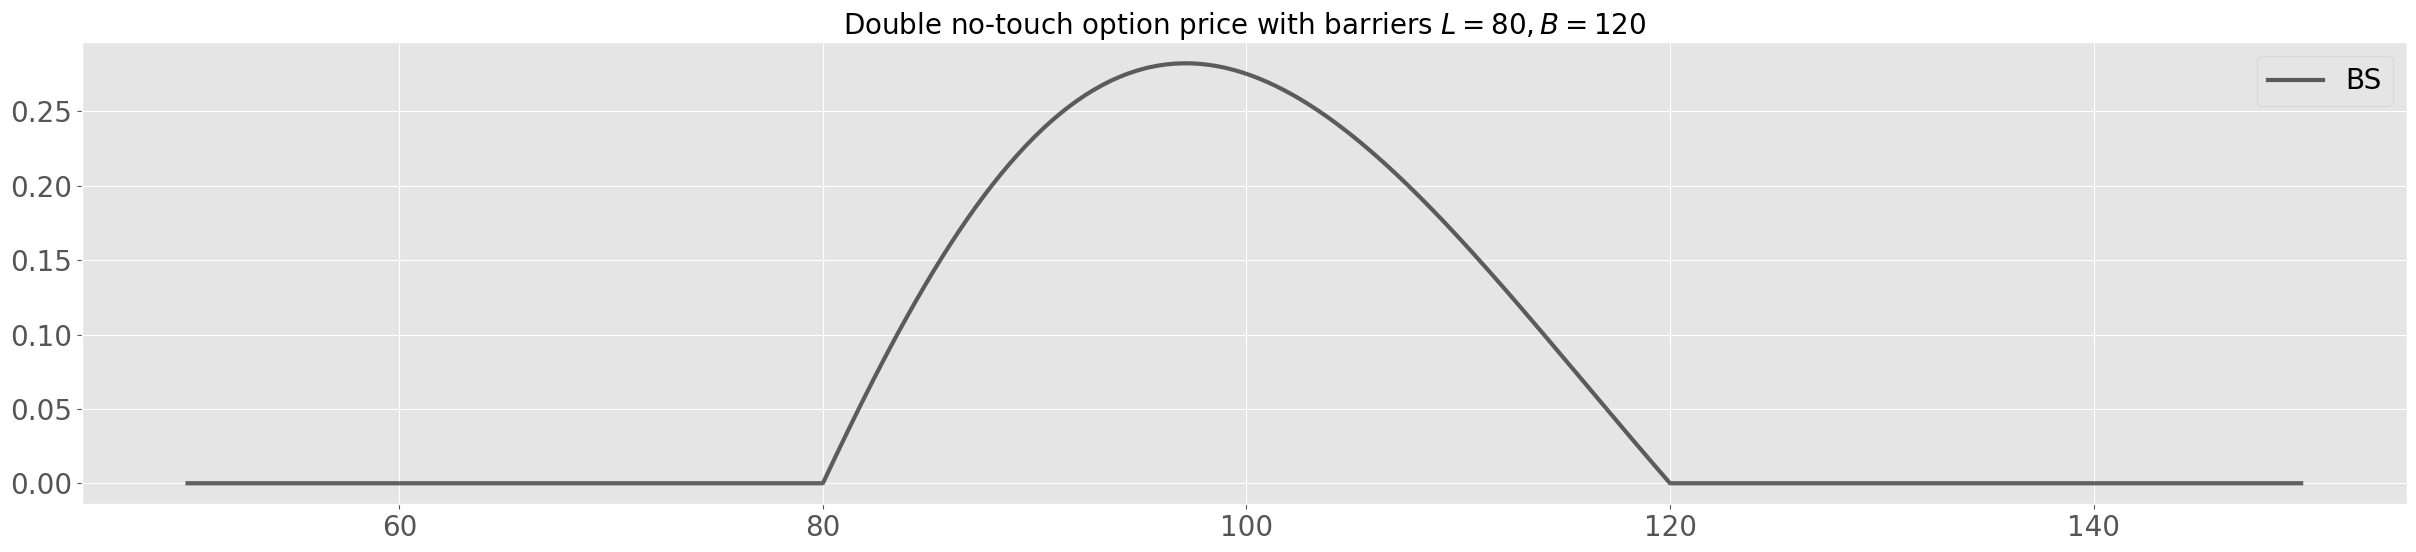

In [7]:
fig, ax = plt.subplots()
ax.plot(underlying, dnt, c='crimson', label='MC', linewidth=3)
ax.plot(underlying, dnt_gobet, c='royalblue', label='MC - Gobet', linewidth=3)
ax.plot(underlying, dnt_bs, c='black', label='BS', linewidth=3, alpha=0.6)
ax.legend()
ax.set_title(r'Double no-touch option price with barriers $L=80, B=120$')

In [71]:
fig.savefig("killed_diffusion/report/img/dnt_mc.pdf", format="pdf", bbox_inches='tight')

# Convergence

In [37]:
# We now fix the underlying current price and play with the number of simulations

S0=100
N_values = [int(i**1.5) for i in range(1,150)]

In [38]:
cuo_conv = []
for n in N_values:
    price = killed_diffusion.price_barrier_call_up_and_out(S0, K, r, T, sigma, n, M, B)
    cuo_conv.append(price)

In [39]:
cuo_gobet_conv = []
for n in N_values:
    price = killed_diffusion.price_barrier_call_up_and_out_gobet(S0, K, r, T, sigma, n, M, B, k_limit=10)
    cuo_gobet_conv.append(price)

Text(0.5, 1.0, 'Error between the MC price and the theoretical price')

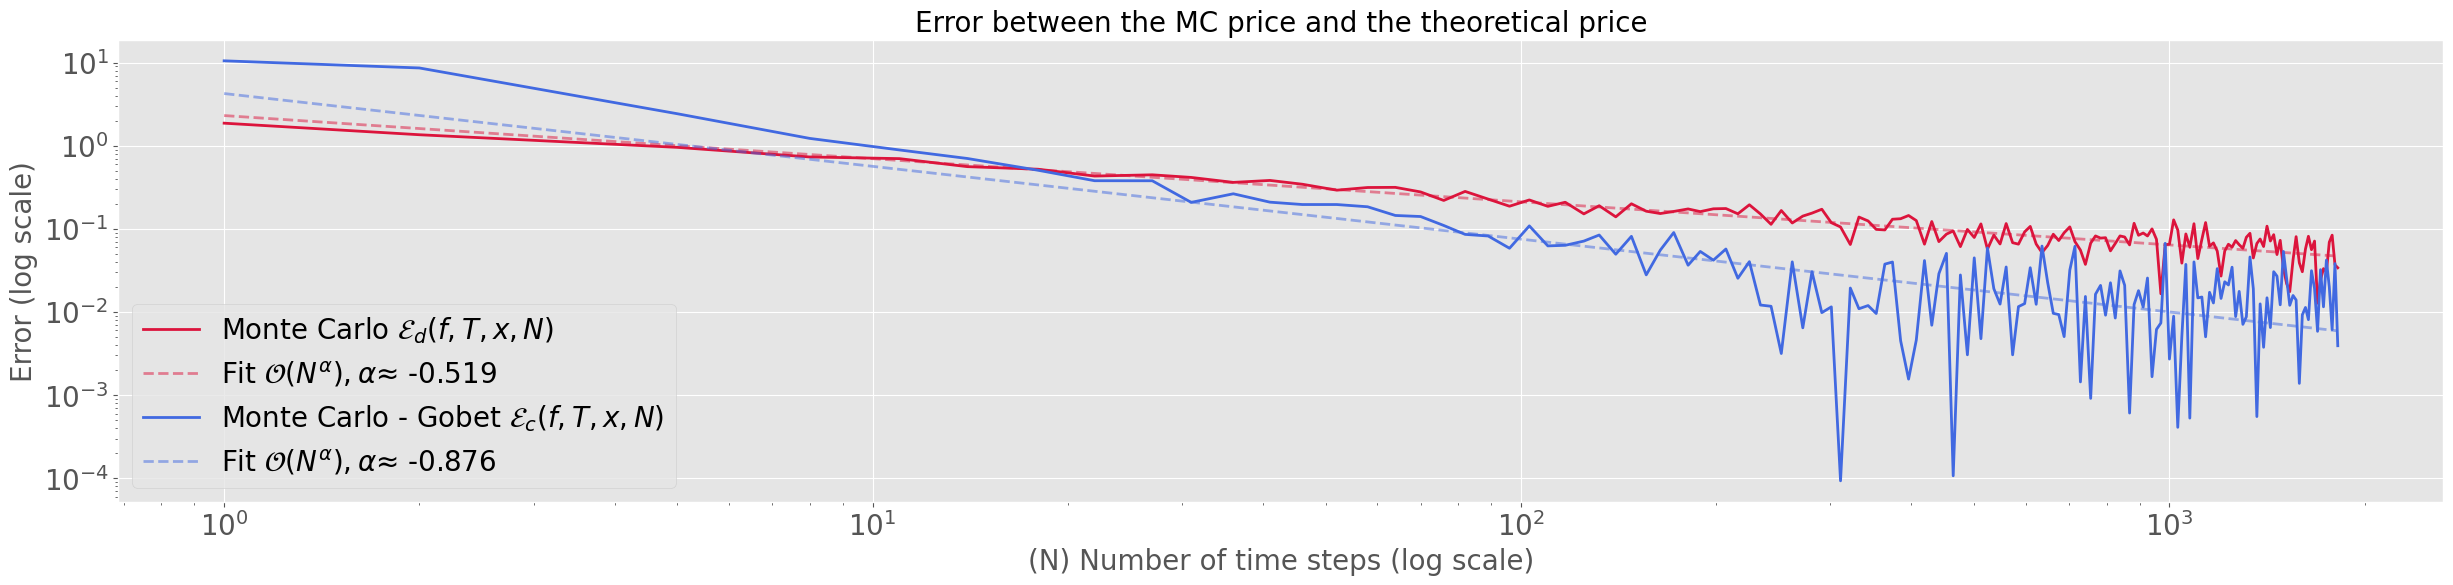

In [40]:
fig, ax = plt.subplots()
theoretical_barrier = killed_diffusion.bs_barrier_call_up_and_out(S0, K, r, T, sigma, B)

# Order of convergence: log-log linear regression to find the slope of the curve
diff_mc = [np.abs(mc_p - theoretical_barrier) for mc_p in cuo_conv]
diff_mc_gobet = [np.abs(mc_p - theoretical_barrier) for mc_p in cuo_gobet_conv]


X = np.log(N_values).reshape(-1, 1)
y = np.log(diff_mc)
reg = LinearRegression().fit(X, y)
y_gobet = np.log(diff_mc_gobet)
reg_gobet = LinearRegression().fit(X, y_gobet)

# Plot the fitted line
alpha = reg.coef_[0]
beta = reg.intercept_
ax.plot(N_values, diff_mc, color='crimson', label='Monte Carlo ' + "$\\mathcal{E}_d(f, T, x, N)$")
ax.plot(np.exp(X), np.exp(alpha*X + beta), linestyle='--', color='crimson', alpha=0.5, label='Fit $\mathcal{O}(N^{\\alpha}), \\alpha$' + f"\u2248 {alpha:.3f}")

alpha_gobet = reg_gobet.coef_[0]
beta_gobet = reg_gobet.intercept_
epsilon_c = np.exp(beta_gobet)
ax.plot(N_values, diff_mc_gobet, color='royalblue',  label='Monte Carlo - Gobet ' + "$\\mathcal{E}_c(f, T, x, N)$")
ax.plot(np.exp(X), np.exp(alpha_gobet*X + beta_gobet), linestyle='--', color='royalblue', alpha=0.5, label='Fit $\mathcal{O}(N^{\\alpha}), \\alpha$' + f"\u2248 {alpha_gobet:.3f}")

ax.legend()
ax.set_xlabel('(N) Number of time steps (log scale)')
ax.set_ylabel('Error (log scale)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title(r'Error between the MC price and the theoretical price')

In [41]:
fig.savefig("killed_diffusion/report/img/convergence.pdf", format="pdf", bbox_inches='tight')

In [5]:
B = np.exp(1)
drift = lambda S: S
sigma = lambda S: 0
S0 = 1
T = 1
f = lambda S, K: 1 # digital option
N_range = [int(i**1.5) for i in range(1,150)]

cuo_conv = []
for n in N_range:
    price = killed_diffusion.price_option_generic(
        S0,
        K,
        r,
        T,
        drift,
        sigma,
        N,
        M,
        L=-10,
        B=B,
        k_limit=10,
        f=f,
        gobet=False,
    )
    cuo_conv.append(price)

cuo_gobet_conv = []
for n in N_range:
    price = killed_diffusion.price_option_generic(
        S0,
        K,
        r,
        T,
        drift,
        sigma,
        N,
        M,
        L=-10,
        B=B,
        k_limit=10,
        f=f,
        gobet=True,
    )
    cuo_gobet_conv.append(price)

TypeError: price_option_generic(): incompatible function arguments. The following argument types are supported:
    1. (S0: float, K: float, r: float, T: float, drift: std::__1::function<double (double)>, sigma: std::__1::function<double (double)>, N: int, M: int, L: float, B: float, k_limit: int, f: std::__1::function<double (double, double)>, gobet: bool) -> float

Invoked with: 1, 100.0, 0.05, 1, <function <lambda> at 0x135d8a8e0>, <function <lambda> at 0x169c372e0>, 500, 15000; kwargs: L=-10, B=2.718281828459045, k_limit=10, f=<function <lambda> at 0x169c37100>, gobet=False

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

In [ ]:
killed_diffusion.price_option_generic()